In [1]:
#import requests
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
import geopandas
import geoplot
import geoplot.crs as gcrs

import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage, TextArea)
import seaborn as sns

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import pyarrow as pa
import pyarrow.parquet as pq
import json

In [48]:
yield_data_polygons['planting_year'].min()

1975

In [2]:
with open('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\downloaded_data\\era_agronomy_bundle_2025-05-12\\era_master_codes-2025-05-12.json', 'r') as file:
    era_master_codes = json.load(file)
era_fields_comp = era_master_codes["era_fields_v1"]
era_fields_comp = pd.DataFrame(era_fields_comp)
#M.year !!!!
#MeanT !!!!
#MeanC !!!!
#Buffer !!!! (meters)
era_fields_comp[era_fields_comp['Description'].str.contains('location', case=False, na=False)]#.loc[71,'Description']#
era_fields_comp.loc[era_fields_comp['Field.Name'] == 'Buffer','Description'].values#]
era_fields_comp['Field.Name'].to_list()
ERA_compiled = pq.read_table('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\downloaded_data\\era_agronomy_bundle_2025-05-12\\era_compiled-v1.0-mh_2025-03-19.2-sc_2025_01_30.1-ie_2025_05_09.2-2025-05-09.1.parquet')
#ERA_compiled#['Product']#.to_pandas()
def compiled_cols_to_pandas(cols):
    yield_data = {col: ERA_compiled[col] for col in cols}
    return pd.DataFrame(yield_data)
ERA_compiled
yd = compiled_cols_to_pandas(['obs_count', 'Out.SubInd', 'M.Year', 'Latitude', 'Longitude', 'MeanC', 'MeanT', 'Buffer'])#, 'Plant.Start', 'Plant.End', 'Harvest.Start', 'Harvest.End',
yd = yd.dropna(subset=['M.Year'], how='all')
yd = yd.dropna(subset = ['Latitude', 'Longitude'], how='all')
yd = yd.loc[yd['M.Year'].str.len() <= 6]
yd.loc[:, 'M.Year'] = yd.loc[:, 'M.Year'].str.replace(r'\D', '', regex=True).str[:4]
yd = yd.loc[yd['M.Year'].str.len() >= 4]
yd.loc[:, 'M.Year'] = yd.loc[:, 'M.Year'].astype(int)
yd = yd.loc[(yd['M.Year'] < 2100) & (yd['M.Year'] >= 1975)]
yd = yd.loc[yd['Out.SubInd'] == 'Crop Yield']
#yd.loc[:, 'Plant.Start'] = pd.to_datetime(yd['Plant.Start'], format='%Y-%m-%d')
#yd['Plant.Start'].max()

In [51]:
yd#.loc[:, 'M.Year'].unique()

,obs_count,Out.SubInd,M.Year,Latitude,Longitude,MeanC,MeanT,Buffer
4,12,Crop Yield,2010,-0.00230,34.59390,4.78,3.970,300.0
5,12,Crop Yield,2010,-0.00230,34.59390,4.78,4.610,300.0
6,12,Crop Yield,2010,-0.00230,34.59390,4.78,4.563,300.0
7,12,Crop Yield,2010,-0.00230,34.59390,4.78,4.496,300.0
24,30,Crop Yield,1987,-0.00230,34.59390,6.38,5.160,300.0
...,...,...,...,...,...,...,...,...
197701,144,Crop Yield,2012,36.84512,10.19245,1.40,7.300,917.0
197702,144,Crop Yield,2012,36.84512,10.19245,1.40,6.200,917.0
197703,144,Crop Yield,2012,36.84512,10.19245,1.40,10.000,917.0
197706,6,Crop Yield,2013,36.84512,10.19245,3.55,2.760,917.0


In [3]:
geometry = geopandas.points_from_xy(yd['Longitude'], yd['Latitude'])
ygd = geopandas.GeoDataFrame(yd, geometry=geometry, crs='EPSG:4326')

In [4]:
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_data.csv')
yield_data = yield_data.loc[(yield_data['product'] == 'Maize')]
kenya_data = yield_data.loc[yield_data['country'] == 'Kenya']
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['fnid']).drop(columns=['admin_1', 'admin_2', 'start_date', 'id'])
yield_data_polygons = adm_data_for_merging.merge(kenya_data, on=['fnid'], how='right')

Skipping field centroid: unsupported OGR type: 3


In [45]:
len(ygd['M.Year'].unique())

63

In [5]:
plantorharvest = 'planting'
era_Kenya = adm_data.overlay(ygd, how='intersection', keep_geom_type=False)
era_Kenya = era_Kenya.loc[(era_Kenya['MeanC'] < 6) & (era_Kenya['MeanT'] < 6)]
era_Kenya['full_mean'] = 0.5*(era_Kenya['MeanC'] + era_Kenya['MeanT'])
era_yields = era_Kenya[['M.Year', 'admin_1', 'MeanC', 'MeanT', 'full_mean']].groupby(['M.Year', 'admin_1']).median()
era_yields = era_yields.reset_index().rename(columns = {'M.Year': f'{plantorharvest}_year'})#.merge(yield_data_)

In [6]:

to_correlate = era_yields.merge(kenya_data[[f'{plantorharvest}_year', 'admin_1', 'yield']], on=[f'{plantorharvest}_year', 'admin_1'], how='left').dropna(subset=['yield'])

<Axes: xlabel='full_mean', ylabel='yield'>

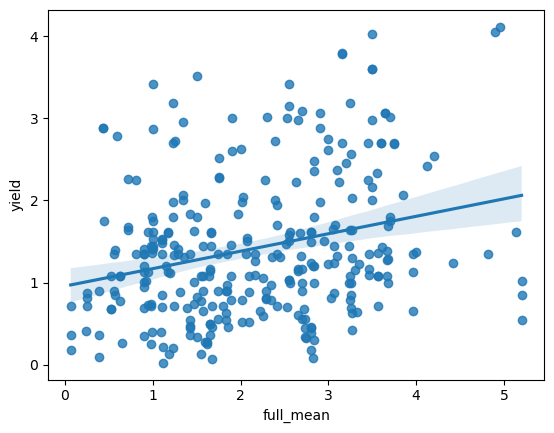

In [7]:
sns.regplot(data=to_correlate, x='full_mean', y='yield')

In [8]:
to_correlate[['yield', 'full_mean']].corr()

,yield,full_mean
yield,1.000000,0.273229
full_mean,0.273229,1.000000


In [12]:
import scipy.stats
scipy.stats.pearsonr(to_correlate['full_mean'], to_correlate['yield'])

PearsonRResult(statistic=np.float64(0.2732289804768079), pvalue=np.float64(1.1701308891644137e-06))

In [ ]:

scipy.stats.ttest_ind(to_correlate['yield'], to_correlate['full_mean'])

TtestResult(statistic=np.float64(-9.351730745430409), pvalue=np.float64(1.6014970514595634e-19), df=np.float64(612.0))